# Characterizing UPEC transcriptional state during *in vivo* infection


This will hopefully correspond to **Figure 2** in the final manuscript. 

* Correlations
    - UR vs UTI
    - B1 vs B2 (in UR and in UTI)
* Transcription across genome
    - Ribosomal genes
    - Other operons of interest
* PCA 
    - UR vs UTI
    - B1 vs B2

### 1. Import and Normalize RPKMs for all 14 strains
    - Using iverse rank normalization
    

In [10]:
import pandas as pd
import os
import numpy as np
import scipy as ss
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("ticks")


# These are RPKMs
data = "/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/DE/data/processed_counts/2018-01-29_combined_counts.csv"


#Normalization Function
def invnorm(x):
    return scipy.stats.norm.ppf((x.rank() -0.5)/x.count())



col1 = "#f34236"
col2 = "#d6c571"
col3 = "#88bc67"
col4 = "#2e8174"
col5 = "#143969"

ur = "URINE"
uti = "PATIENT"

In [4]:
counts = pd.read_csv(data, index_col=0)
to_drop = [c for c in list(counts.columns) if 'counts' in c or 'Unnamed' in c or 'seq' in c]
to_drop.append('MG1655')

# Only interested in RPKMs and core genome, but without MG1655
counts.drop(to_drop, axis=1, inplace=True)
counts.dropna(inplace=True)
counts.set_index('CFT073', inplace=True)
counts = counts.select_dtypes(include=["float64"])

//anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,8,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


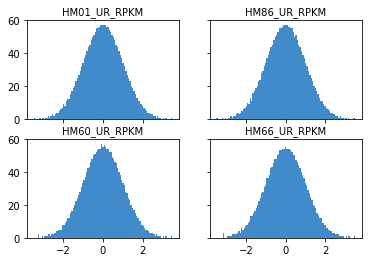

In [7]:
#Applying to the RPKMs
cc_norm = counts.apply(invnorm)

#Draw histograms for a couple to make sure normal distribution: HM01, HM86, HM60, HM66
# For HM01 and HM86 have good coverge for UTI samples, not so for HM60 and HM66
sam = ["HM01", "HM86", "HM60", "HM66"]
ur_suffix = "_UR_RPKM"
uti_suffix = "_UTI_RPKM"

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
axs = [ax1,ax2,ax3,ax4]

#Urine histograms
for n in range(len(sam)):
    sample = sam[n]+ur_suffix
    axs[n].hist(cc_norm[sample], 100, color = "#428bca")
    axs[n].set_title(sample, fontsize=10)

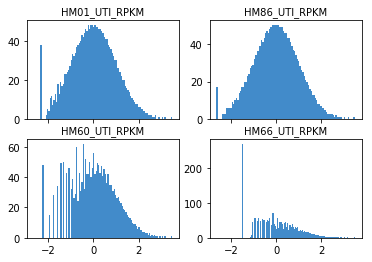

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True)
axs = [ax1,ax2,ax3,ax4]
#UTI histograms
for n in range(len(sam)):
    sample = sam[n]+uti_suffix
    axs[n].hist(cc_norm[sample], 100, color = "#428bca")
    axs[n].set_title(sample, fontsize=10)

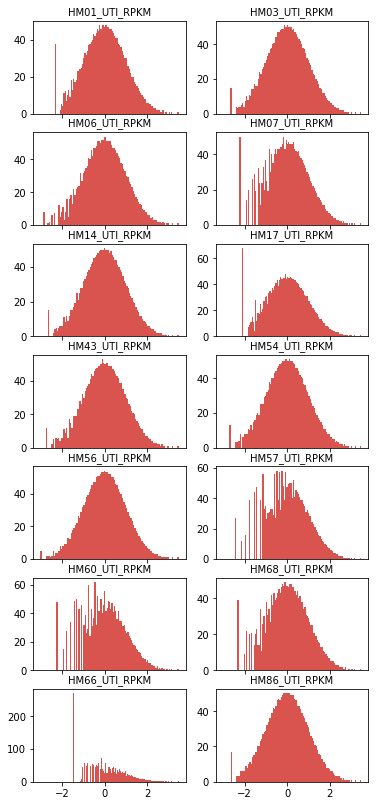

In [9]:
#HM66 looks bad, going to check all of the UTI samples
fig, ((ax1, ax2), (ax3, ax4),
     (ax5,ax6), (ax7, ax8),
     (ax9, ax10), (ax11, ax12),
     (ax13, ax14)) = plt.subplots(7, 2, sharex=True)
axs = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14]
#plt.figure(figuresize)
uti_col=[c for c in list(cc_norm.columns) if "UTI" in c]

for n in range(len(uti_col)):
    sample = uti_col[n]
    axs[n].hist(cc_norm[sample], 100, color = "#d9534f")
    axs[n].set_title(sample, fontsize=10)   
fig = plt.gcf()
fig.set_size_inches(6,14)

#HM66 is not good! Others look ok (Maybe HM54)

### 2. Look at correlation in gene expression between UR and UTI samples
#### 2.1 Draw scatter plots with UR samples on Y-axis and UTI samples on X-axis


['HM01', 'HM86', 'HM60', 'HM66']

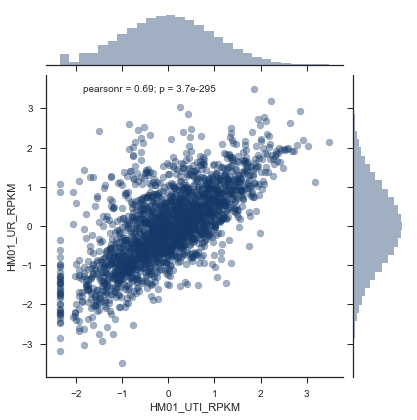

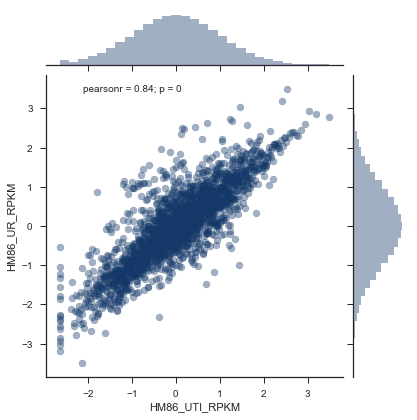

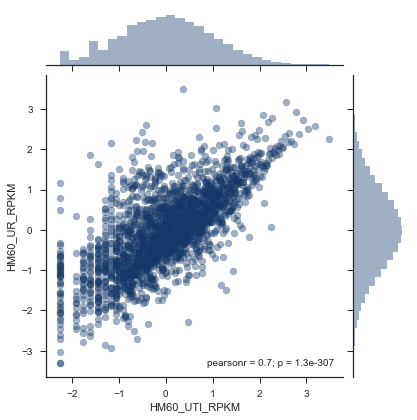

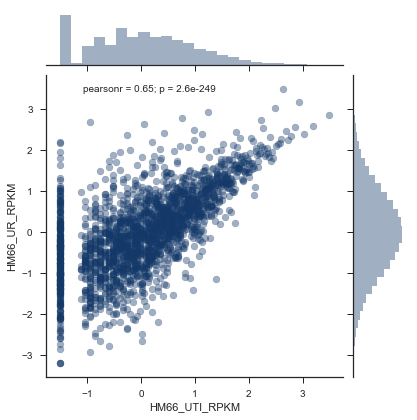

In [14]:

for s in sam:
    v1 = cc_norm[s+uti_suffix]
    v2 = cc_norm[s+ur_suffix]
    f = sns.jointplot(v1, v2, color = col5, alpha=0.4);


<IPython.core.display.Javascript object>


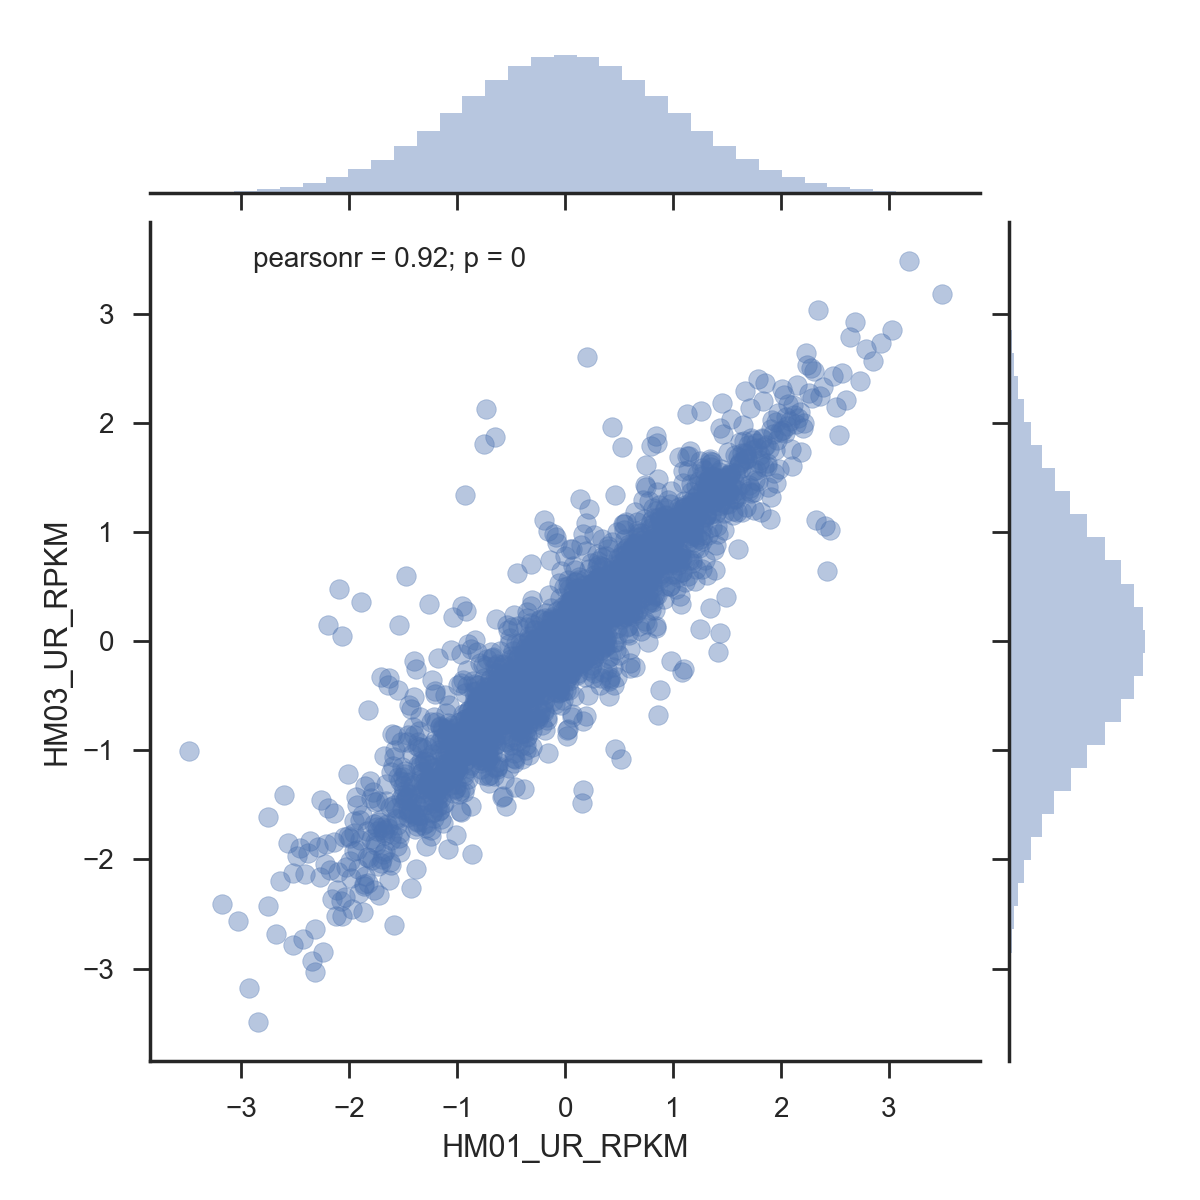

In [16]:
v1 = cc_norm["HM01_UR_RPKM"]
v2 = cc_norm["HM03_UR_RPKM"]
f = sns.jointplot(v1, v2, alpha=0.4);

#### 2.2 Calculate Person correlations

Between all strains:

In [9]:
import itertools

uti_col=[c for c in list(cc_norm.columns) if "UTI" in c]
ur_col = [c for c in list(cc_norm.columns) if "UR" in c]

uti_tuples = list(itertools.combinations(uti_col, 2))
ur_tuples = list(itertools.combinations(ur_col,2))
ur_vs_uti = list(itertools.product(ur_col, uti_col))

ur_corr = [cc_norm[t[0]].corr(cc_norm[t[1]], method='pearson') for t in ur_tuples]                    
uti_corr = [cc_norm[t[0]].corr(cc_norm[t[1]], method='pearson') for t in uti_tuples]
ur_vs_uti = [cc_norm[t[0]].corr(cc_norm[t[1]], method='pearson') for t in ur_vs_uti]
own_strain = [cc_norm[u].corr(cc_norm[t], method='pearson') for u,t in zip(ur_col, uti_col)]

ur_df = pd.DataFrame({"sample":["UR/UR"]*len(ur_corr), "pearson":ur_corr})
uti_df = pd.DataFrame({"sample":["UTI/UTI"]*len(uti_corr), "pearson":uti_corr})
ur_vs_uti_df = pd.DataFrame({"sample":["UR/UTI"]*len(ur_vs_uti), "pearson":ur_vs_uti})
os_df = pd.DataFrame({"sample":["UR/UTI:matched"]*len(own_strain), "pearson":own_strain})

data = pd.concat([ur_df, uti_df, ur_vs_uti_df, os_df])


<IPython.core.display.Javascript object>


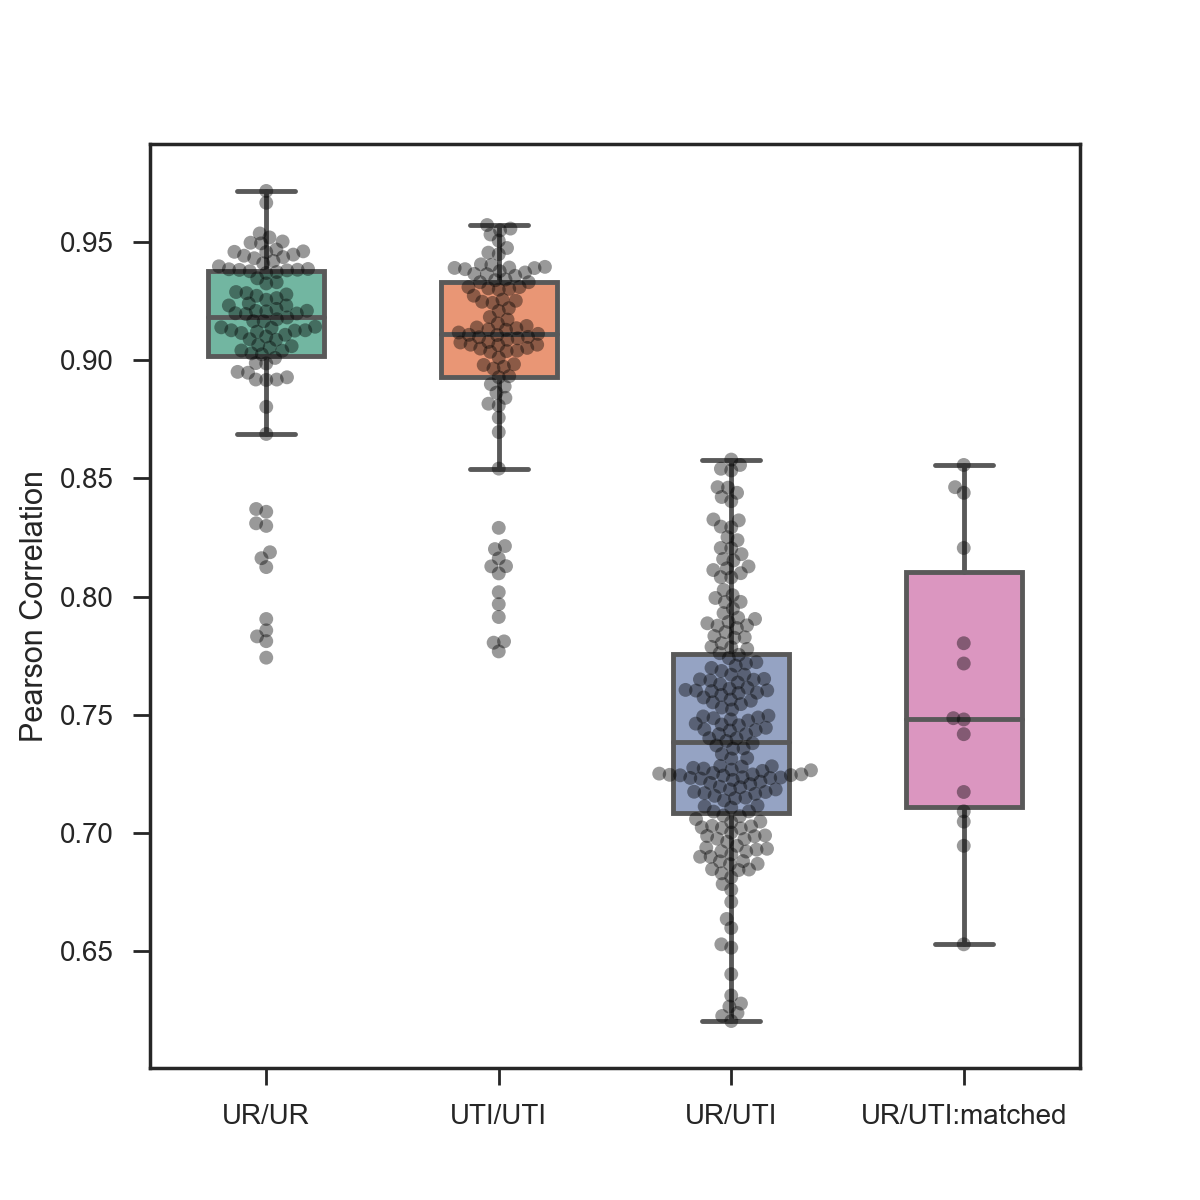

In [10]:
plt.figure(figsize=(6,6))
ax = sns.boxplot(x = "sample", y = "pearson", data = data, palette="Set2", width=.5, showfliers=False)
ax = sns.swarmplot(x = "sample", y = "pearson", data = data, color = 'black', alpha = 0.4)
ax.set(xlabel='', ylabel='Pearson Correlation')
plt.show()

By phylogroup:

In [11]:
b1 = ["HM03", "HM07", "HM14", "HM60"]
e = ["HM01"]

# Variables: b1, b2, ur, uti
def getCombinations(samples):#passing in a list of lists
    sampl_dict = {}
    for s in samples:
        sample_dict[s] = list(itertools.combinations(s, 2))
        
    prod = list(itertools.combinations(samples, 2))
    for p in prod:
        sample_dict[p]
    return sample_dict


In [12]:
b1 = ["HM03", "HM07", "HM14", "HM60"]
e = ["HM01"]
b1_ur = [s for s in ur_col if s.split('_')[0] in b1]
b2_ur = [s for s in ur_col if s.split('_')[0] not in (b1 + e)]
b1_uti = [s for s in uti_col if s.split('_')[0] in b1]
b2_uti = [s for s in uti_col if s.split('_')[0] not in (b1 + e)]

b2_uti_tuples = list(itertools.combinations(b2_uti, 2))
b2_ur_tuples = list(itertools.combinations(b2_ur, 2))
b1_uti_tuples = list(itertools.combinations(b1_uti, 2))
b1_ur_tuples = list(itertools.combinations(b1_ur, 2))
b1_b2_uti_tuples = list(itertools.product(b1_uti, b2_uti))
b1_b2_ur_tuples = list(itertools.product(b1_ur, b2_ur))


b2_ur_corr = [cc_norm[t[0]].corr(cc_norm[t[1]], method='pearson') for t in b2_ur_tuples]                    
b2_uti_corr = [cc_norm[t[0]].corr(cc_norm[t[1]], method='pearson') for t in b2_uti_tuples]
b1_ur_corr = [cc_norm[t[0]].corr(cc_norm[t[1]], method='pearson') for t in b1_ur_tuples]                    
b1_uti_corr = [cc_norm[t[0]].corr(cc_norm[t[1]], method='pearson') for t in b1_uti_tuples]
b1_b2_uti_corr = [cc_norm[t[0]].corr(cc_norm[t[1]], method='pearson') for t in b1_b2_uti_tuples]
b1_b2_ur_corr = [cc_norm[t[0]].corr(cc_norm[t[1]], method='pearson') for t in b1_b2_ur_tuples]

b2_ur_df = pd.DataFrame({"sample":["B2|UR"]*len(b2_ur_corr), "pearson":b2_ur_corr})
b2_uti_df = pd.DataFrame({"sample":["B2|UTI"]*len(b2_uti_corr), "pearson":b2_uti_corr})
b1_ur_df = pd.DataFrame({"sample":["B1|UR"]*len(b1_ur_corr), "pearson":b1_ur_corr})
b1_uti_df = pd.DataFrame({"sample":["B1|UTI"]*len(b1_uti_corr), "pearson":b1_uti_corr})
b1_b2_uti_df = pd.DataFrame({"sample":["B1|B2|UTI"]*len(b1_b2_uti_corr), "pearson":b1_b2_uti_corr})
b1_b2_ur_df = pd.DataFrame({"sample":["B1|B2|UR"]*len(b1_b2_ur_corr), "pearson":b1_b2_ur_corr})


data_ur = pd.concat([b2_ur_df,  b1_ur_df, b1_b2_ur_df])


<IPython.core.display.Javascript object>


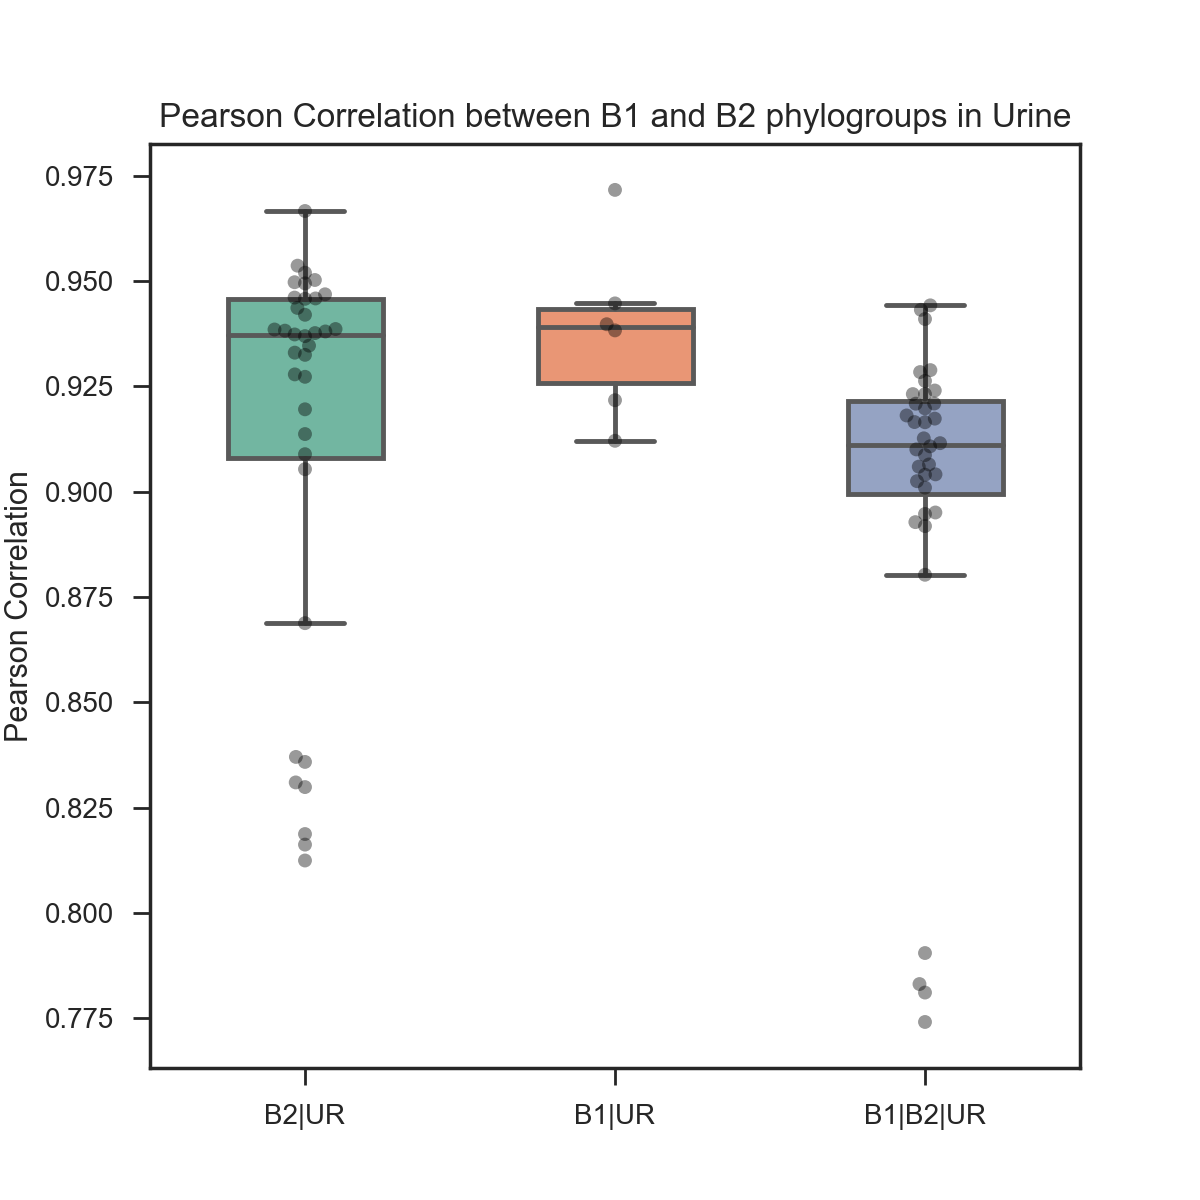

In [13]:
sns.set_style("ticks")
plt.figure(figsize=(6,6))
ax = sns.boxplot(x = "sample", y = "pearson", data = data_ur, palette="Set2", width=.5, showfliers=False)
ax = sns.swarmplot(x = "sample", y = "pearson", data = data_ur, color="black", alpha = 0.4)
ax.set(title= "Pearson Correlation between B1 and B2 phylogroups in Urine", xlabel='', ylabel='Pearson Correlation')
plt.show()


<IPython.core.display.Javascript object>


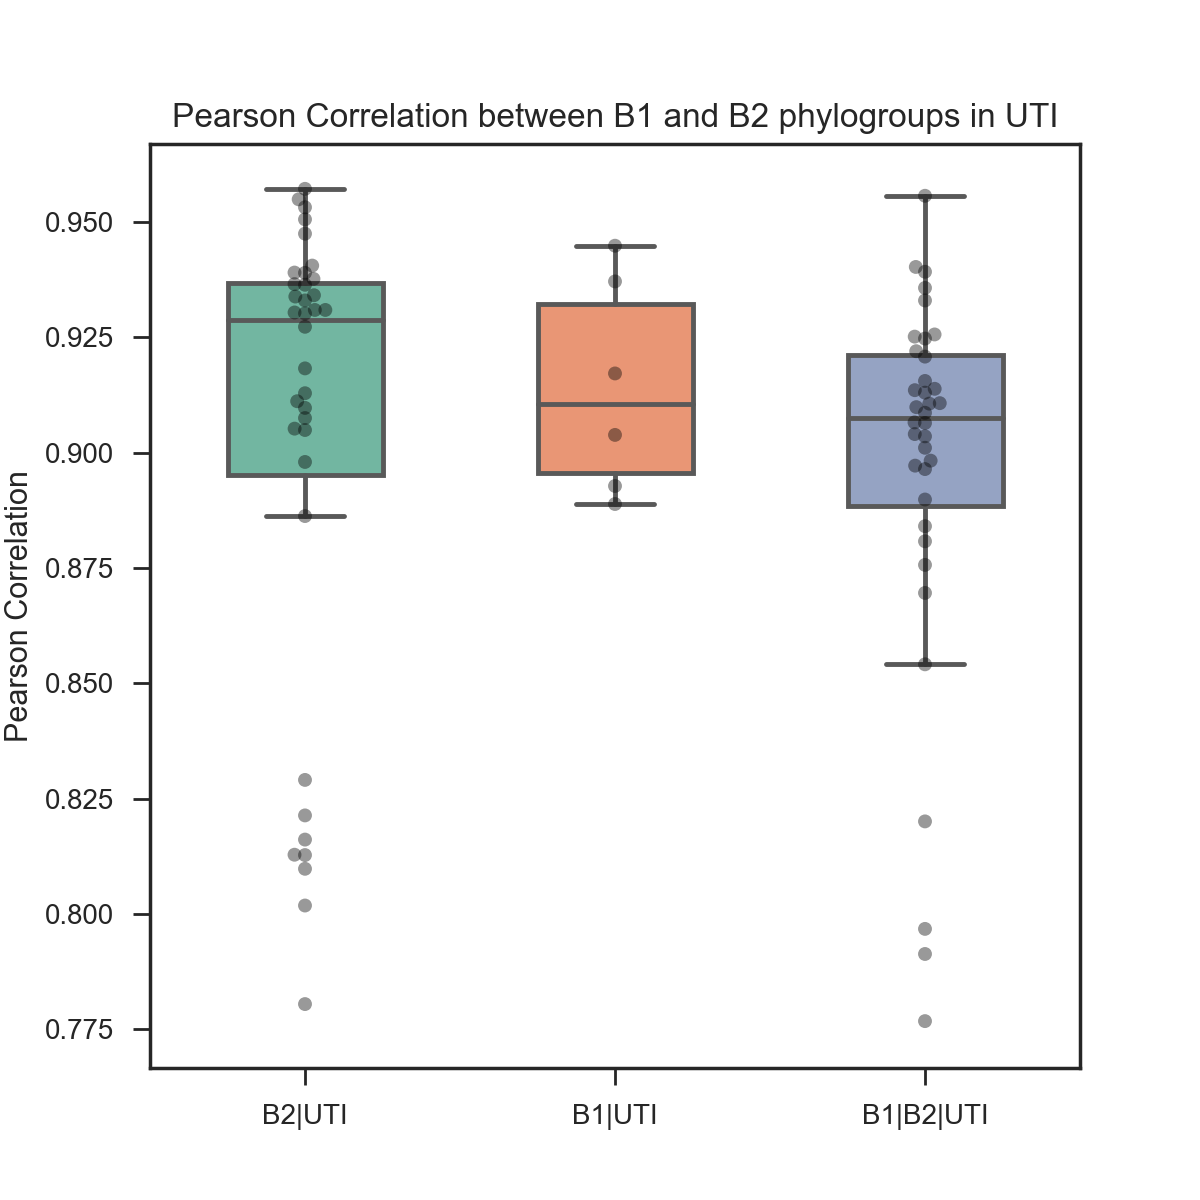

In [14]:
data_uti = pd.concat([b2_uti_df,b1_uti_df,b1_b2_uti_df])
plt.figure(figsize=(6,6))
ax = sns.boxplot(x = "sample", y = "pearson", data = data_uti, palette="Set2", width=.5, showfliers=False)
ax = sns.swarmplot(x = "sample", y = "pearson", data = data_uti, color="black", alpha = 0.4)
ax.set(title= "Pearson Correlation between B1 and B2 phylogroups in UTI", xlabel='', ylabel='Pearson Correlation')
plt.show()

#### 2.3 PCA analysis

In [18]:
pca_table = cc_norm.T

pca_table.head()

CFT073,c0382,c0387,c0417,c0478,c0716,c1155,c1683,c2266,c2615,c3022,...,c5474,c5478,c5479,c5480,c5481,c5482,c5483,c5485,c5488,c5490
HM01_UR_RPKM,-1.797886,1.565094,-0.060563,-1.398539,-0.176374,1.305545,-1.644854,-0.730838,-0.187563,-2.243291,...,-0.416460,0.689921,-0.208762,-0.212512,-0.259033,0.119502,1.188506,0.021400,1.393679,-0.260298
HM01_UTI_RPKM,-1.873672,0.536364,-0.763982,-1.403433,-0.743675,-0.434532,-1.384055,-0.346748,-0.290780,-1.236972,...,0.270430,1.206033,-0.100434,0.150969,-0.238853,0.204390,0.660738,0.096133,0.497234,-0.120733
HM03_UR_RPKM,-1.440394,1.457864,-0.409137,-0.856525,-0.226290,1.147392,-1.709723,-0.882399,0.091221,-2.848670,...,-0.299721,0.570568,-0.211262,-0.067915,-0.196281,0.206263,1.049069,-0.811509,1.413322,-0.108425
HM03_UTI_RPKM,-1.217498,0.781286,-0.650883,-1.024994,-0.957061,-0.043421,-2.682058,-0.613551,0.028738,-2.682058,...,0.348697,0.948398,-0.380058,0.220022,-0.165208,0.413129,0.710231,-0.364332,0.657699,0.178859
HM06_UR_RPKM,-1.216217,1.430119,0.190052,-0.705518,-0.647110,1.649602,-1.410010,-0.685274,0.166447,-2.567486,...,0.076496,0.551960,-0.159013,-0.294609,-0.606922,0.325400,0.950317,-0.110885,1.244894,-0.290780


In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_table)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.set_index(pca_table.index, inplace=True)
principalDf.head()

,principal component 1,principal component 2
HM01_UR_RPKM,-15.269585,1.172566
HM01_UTI_RPKM,16.142744,-4.146577
HM03_UR_RPKM,-15.861711,4.416765
HM03_UTI_RPKM,14.964713,-1.883474
HM06_UR_RPKM,-10.748374,0.774322


In [20]:
names =['UR', 'UTI']*14
pca_table['names'] = names

In [21]:
finalDf = pd.concat([principalDf, pca_table[['names']]], axis=1)
finalDf.index
new_index = [i.split("_RPKM")[0] for i in list(finalDf.index)]
finalDf['new_index'] = new_index
finalDf.set_index('new_index', inplace=True)
finalDf.head()

,principal component 1,principal component 2,names
new_index,,,
HM01_UR,-15.269585,1.172566,UR
HM01_UTI,16.142744,-4.146577,UTI
HM03_UR,-15.861711,4.416765,UR
HM03_UTI,14.964713,-1.883474,UTI
HM06_UR,-10.748374,0.774322,UR


<IPython.core.display.Javascript object>


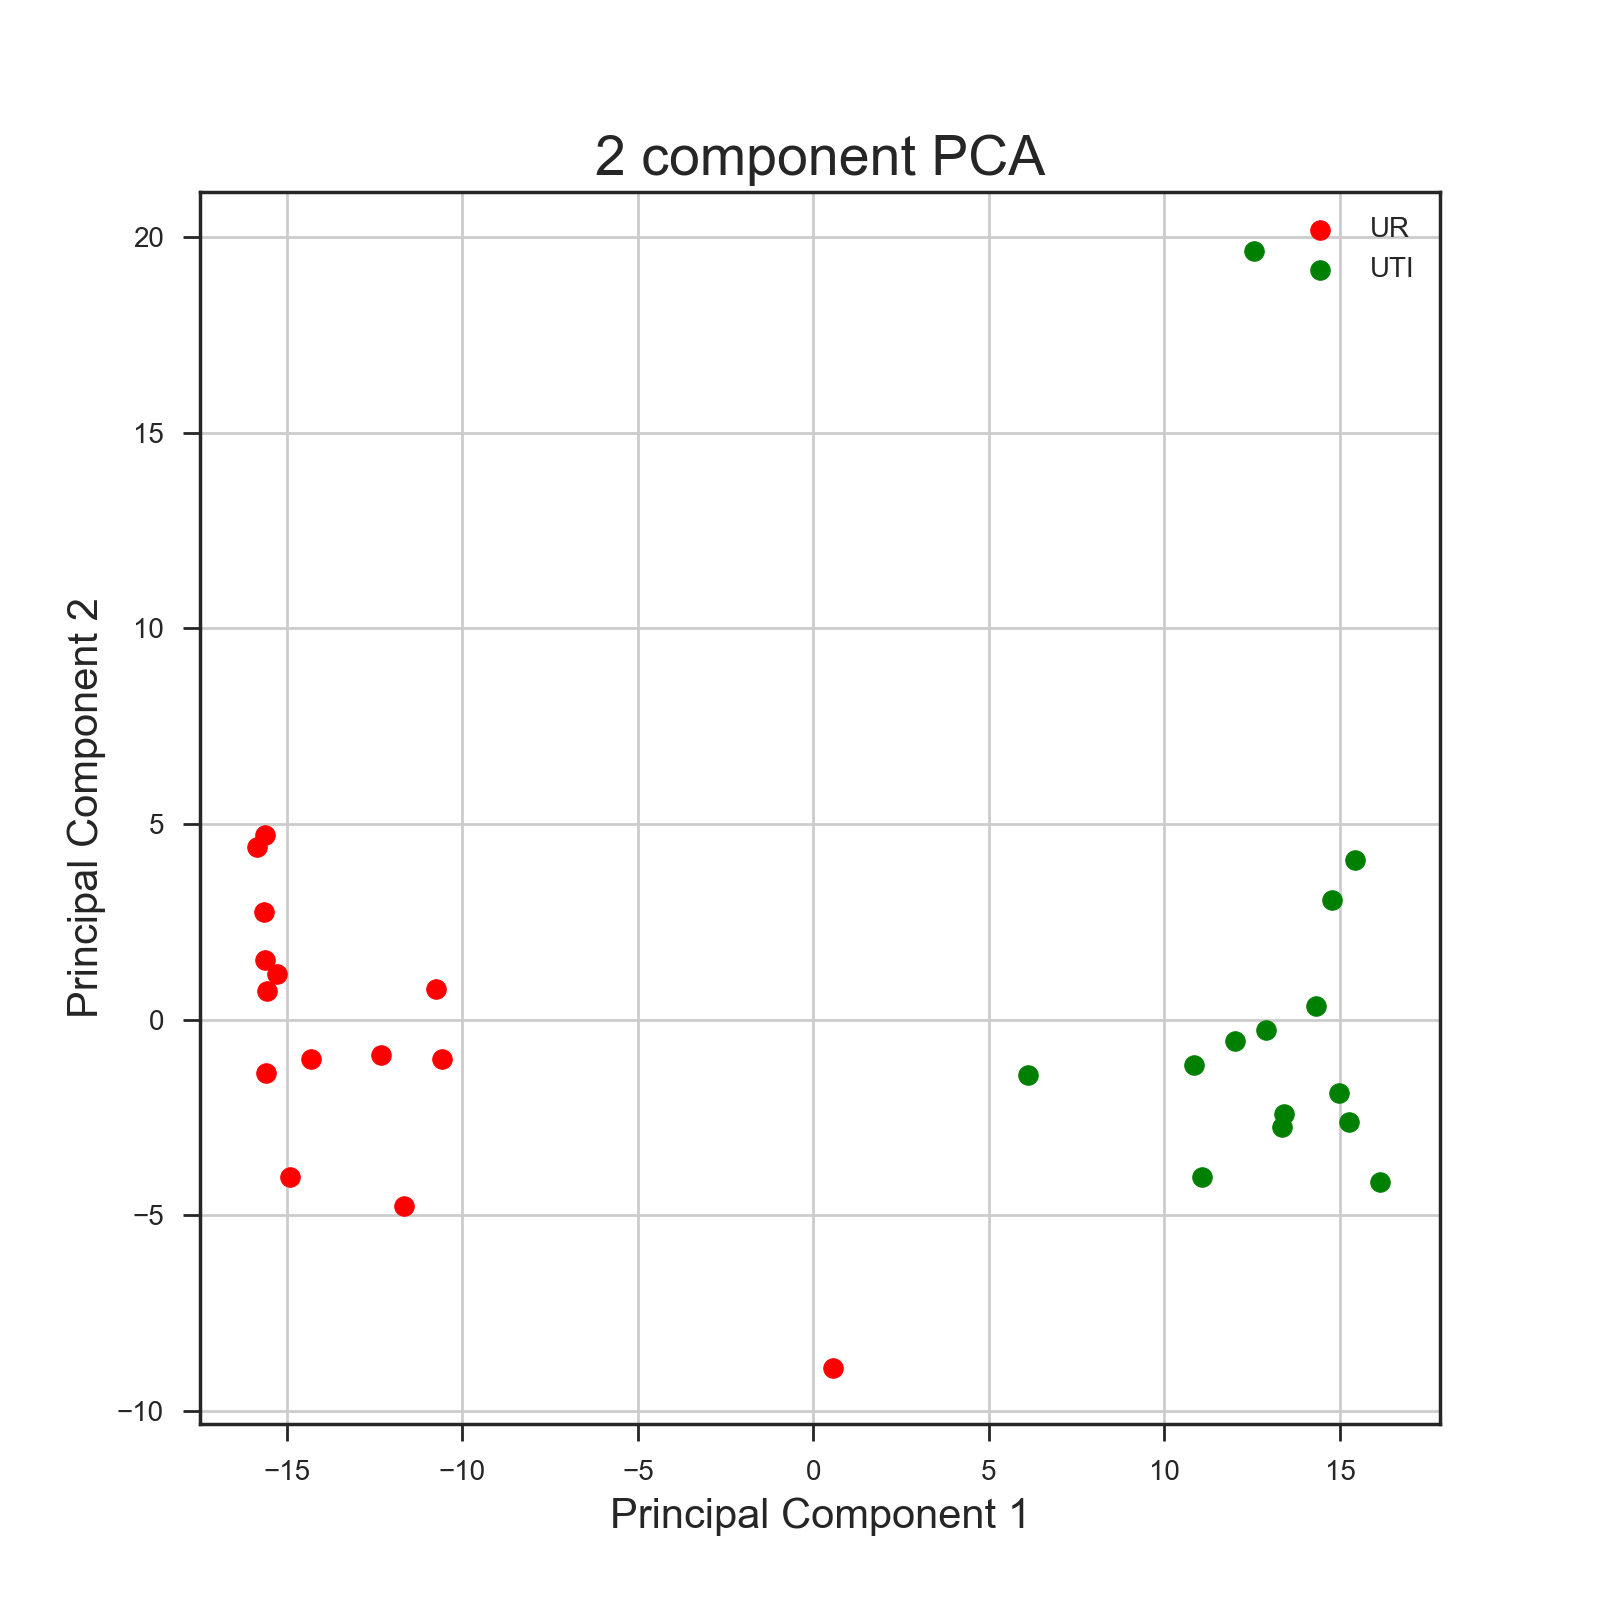

In [22]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ["UR", "UTI"]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['names'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
#Add genome lables, phylogroup labels 

In [23]:
metadata="/Users/annasintsova/git_repos/HUTI-RNAseq/analysis/DE/data/Patient_meta_info.csv"
meta = pd.read_csv(metadata)
meta.head()

,Unnamed: 0,STRAIN,MEDIA,PHYLOGROUP,HISTORY,PRED_PHYLO,EPI_CELLS,RBC,ANCESTRY
0,UR1,HM1,UR,E,N,E,S,A,A
1,UTI1,HM1,UTI,E,N,E,S,A,A
2,UR3,HM3,UR,B1,N,B1,S,N,B
3,UTI3,HM3,UTI,B1,N,B1,S,N,B
4,UR6,HM6,UR,B2,N,B2,S,A,C


In [24]:
new_strains = {"HM1":"HM01", "HM3":"HM03", "HM6":"HM06", "HM7":"HM07"}
meta["STRAIN"] = [new_strains[s] if s in new_strains.keys() else s for s in meta["STRAIN"]]
new_index = meta["STRAIN"]+"_" + meta["MEDIA"]
meta.set_index(new_index, inplace=True)
meta

,Unnamed: 0,STRAIN,MEDIA,PHYLOGROUP,HISTORY,PRED_PHYLO,EPI_CELLS,RBC,ANCESTRY
HM01_UR,UR1,HM01,UR,E,N,E,S,A,A
HM01_UTI,UTI1,HM01,UTI,E,N,E,S,A,A
HM03_UR,UR3,HM03,UR,B1,N,B1,S,N,B
HM03_UTI,UTI3,HM03,UTI,B1,N,B1,S,N,B
HM06_UR,UR6,HM06,UR,B2,N,B2,S,A,C
HM06_UTI,UTI6,HM06,UTI,B2,N,B2,S,A,C
HM07_UR,UR7,HM07,UR,B1,Y,B1,S,N,B
HM07_UTI,UTI7,HM07,UTI,B1,Y,B1,S,N,B
HM14_UR,UR14,HM14,UR,B1,Y,B1,F,N,B
HM14_UTI,UTI14,HM14,UTI,B1,Y,B1,F,N,B


In [25]:
finalDf2 = finalDf.merge(meta, how="outer", left_index=True, right_index=True)
finalDf2.head()

,principal component 1,principal component 2,names,Unnamed: 0,STRAIN,MEDIA,PHYLOGROUP,HISTORY,PRED_PHYLO,EPI_CELLS,RBC,ANCESTRY
HM01_UR,-15.269585,1.172566,UR,UR1,HM01,UR,E,N,E,S,A,A
HM01_UTI,16.142744,-4.146577,UTI,UTI1,HM01,UTI,E,N,E,S,A,A
HM03_UR,-15.861711,4.416765,UR,UR3,HM03,UR,B1,N,B1,S,N,B
HM03_UTI,14.964713,-1.883474,UTI,UTI3,HM03,UTI,B1,N,B1,S,N,B
HM06_UR,-10.748374,0.774322,UR,UR6,HM06,UR,B2,N,B2,S,A,C


<IPython.core.display.Javascript object>


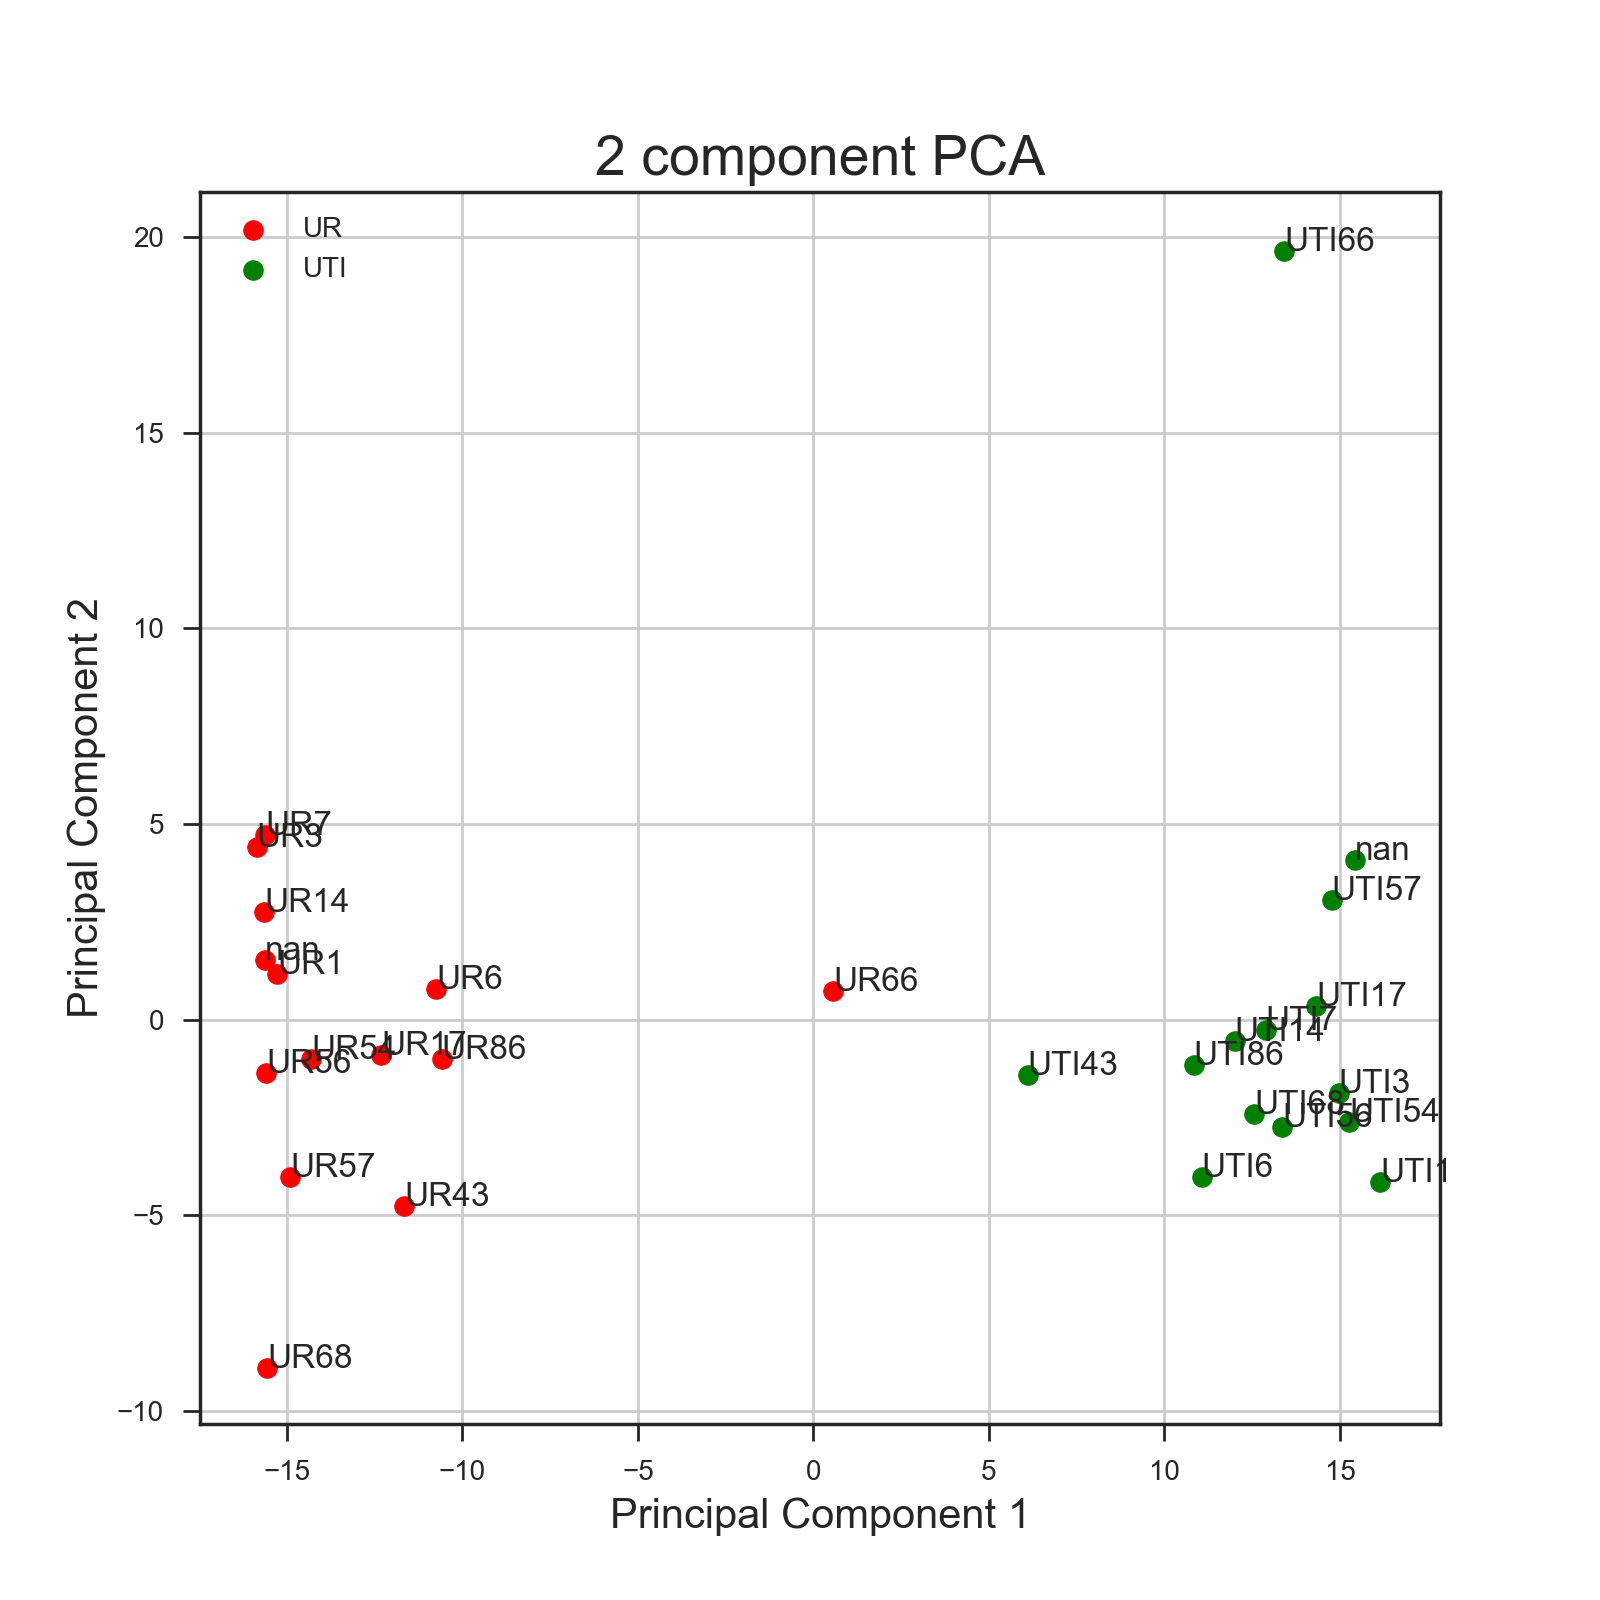

In [26]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ["UR", "UTI"]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf2['names'] == target
    labels = finalDf2.loc[indicesToKeep, 'Unnamed: 0']
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf2.loc[indicesToKeep, 'principal component 2']
    ax.scatter(x, y, c = color, s = 50)
    
    for i in range(len(x)):
        xy = (x[i], y[i])
        label = labels[i]
        ax.annotate(label, xy)
#ax.annotate(labels, (x,y))
ax.legend(targets)
ax.grid()

<IPython.core.display.Javascript object>


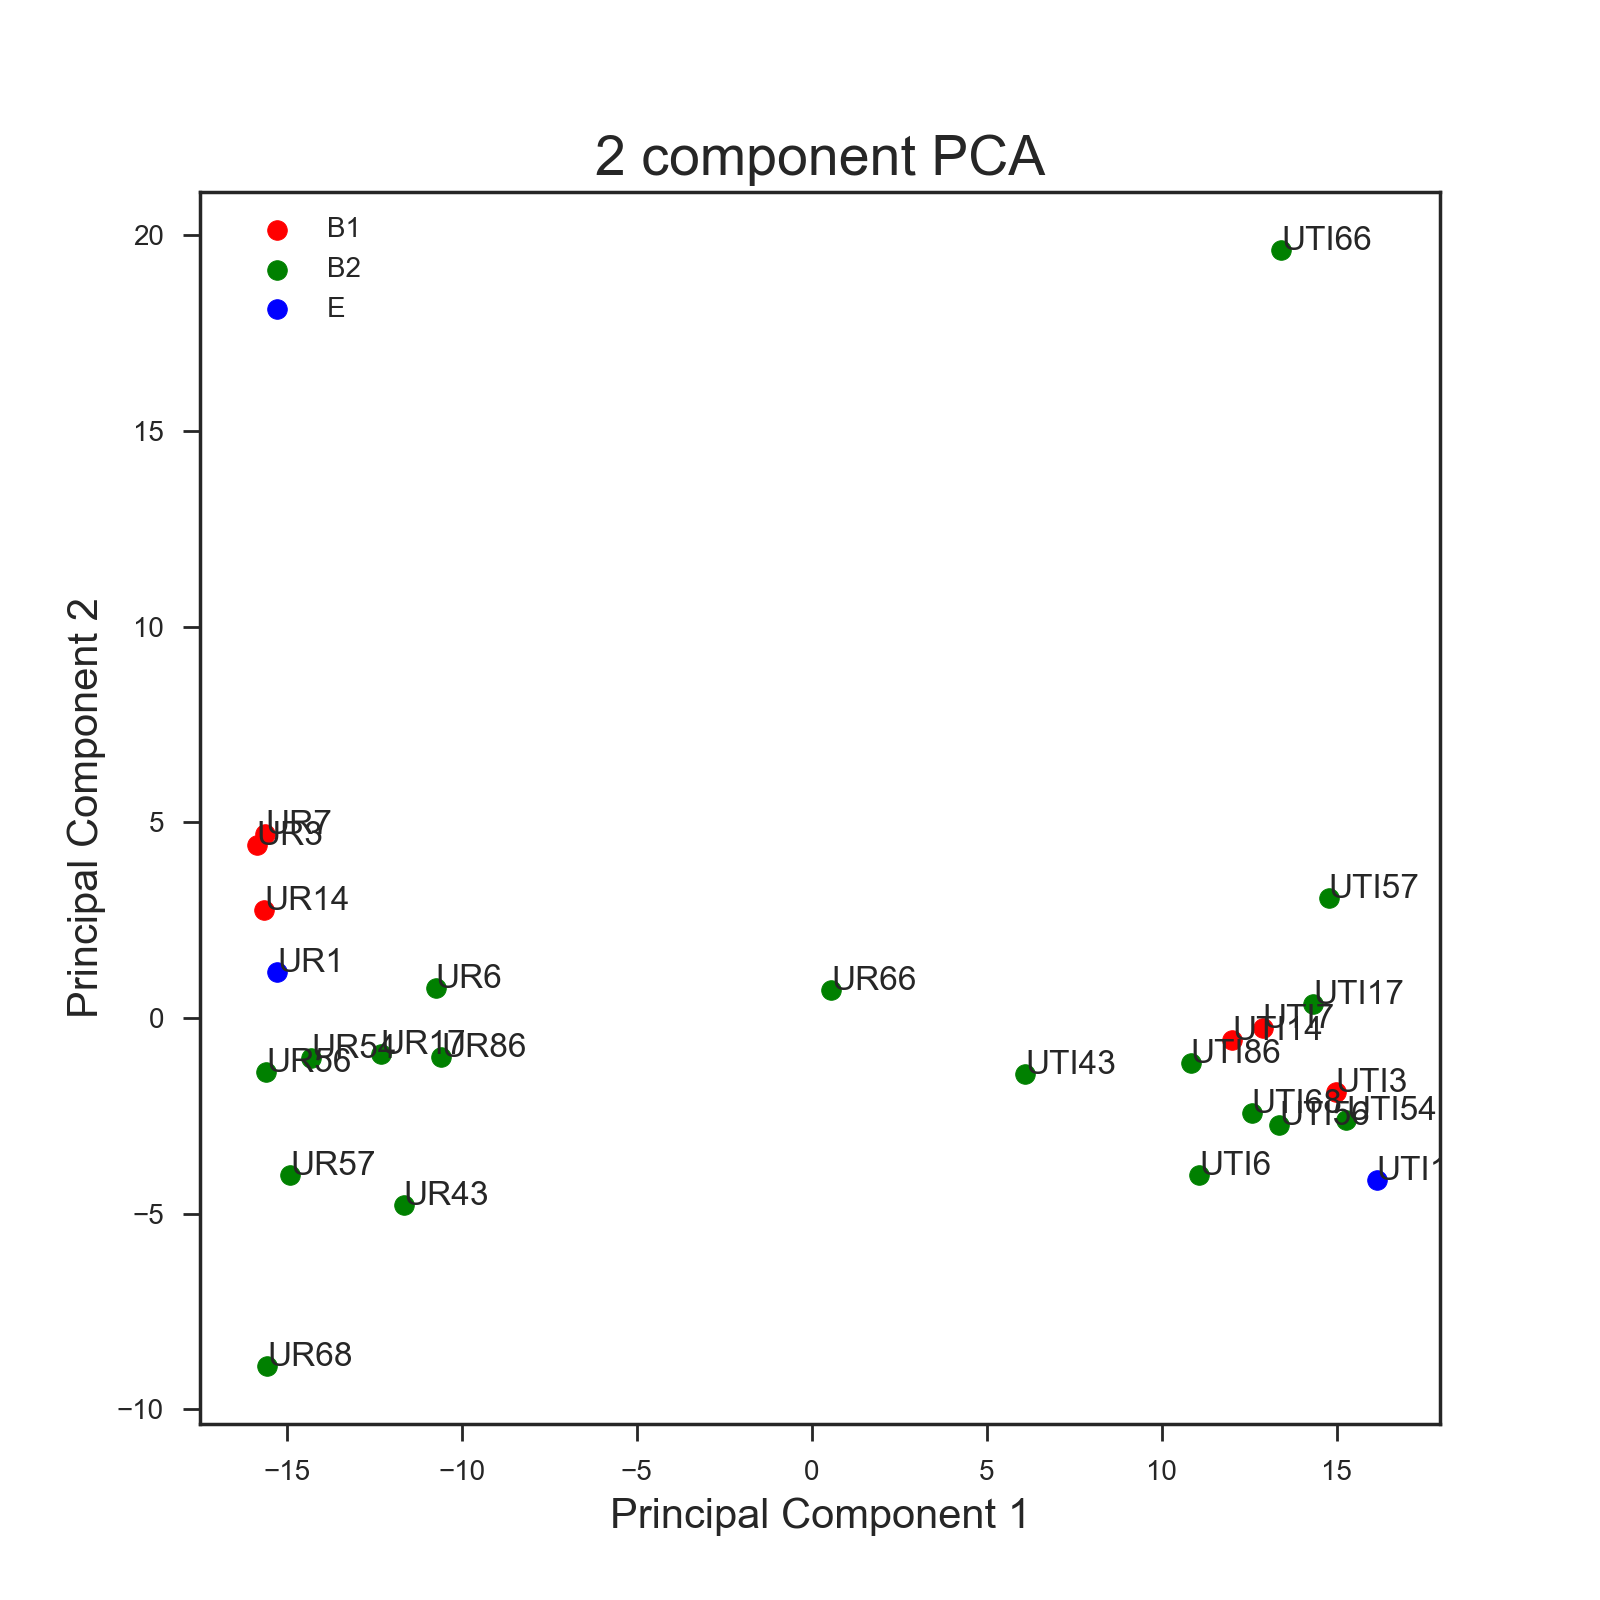

In [34]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ["B1", "B2", "E"]
colors = ['r', 'g', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf2['PRED_PHYLO'] == target
    labels = finalDf2.loc[indicesToKeep, 'Unnamed: 0']
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf2.loc[indicesToKeep, 'principal component 2']
    ax.scatter(x, y, c = color, s = 50)
    
    for i in range(len(x)):
        xy = (x[i], y[i])
        label = labels[i]
        ax.annotate(label, xy)
#ax.annotate(labels, (x,y))
ax.legend(targets, bbox_to_anchor=(0.15, 1))


//anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,8,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:

counts2 = pd.read_csv(data, index_col=0)

to_drop = [c for c in list(counts.columns) if 'counts' in c or 'Unnamed' in c or 'seq' in c]


gpg = ['b3429',
'b3430',
'b3431',
'b3432',
'b3433',
'b3434']

counts2.drop(to_drop, axis=1, inplace=True)
counts2.dropna(subset = ["MG1655"], inplace=True)

counts2.set_index('MG1655', inplace=True)
gpg_df = counts2.ix[gpg]
to_keep = [c for c in list(gpg_df.columns) if 'RPKM' in c and 'seq' not in c]
gpg_df = gpg_df[to_keep].T
gpg_df['names'] = [i.split("_")[1] for i in list(gpg_df.index)]
gpg_df.head()

#counts2.head()
#counts2 = counts.select_dtypes(include=["float64"])

//anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (6,8,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MG1655,b3429,b3430,b3431,b3432,b3433,b3434,names
HM01_UR_RPKM,233.95,359.43,154.18,171.22,712.25,50.62,UR
HM01_UTI_RPKM,3.24,4.93,1.92,3.54,23.58,6.84,UTI
HM03_UR_RPKM,231.69,372.78,123.28,168.42,621.88,52.20,UR
HM03_UTI_RPKM,8.94,16.15,7.02,9.84,53.49,32.11,UTI
HM06_UR_RPKM,237.91,347.36,141.07,153.00,422.11,53.20,UR


<IPython.core.display.Javascript object>


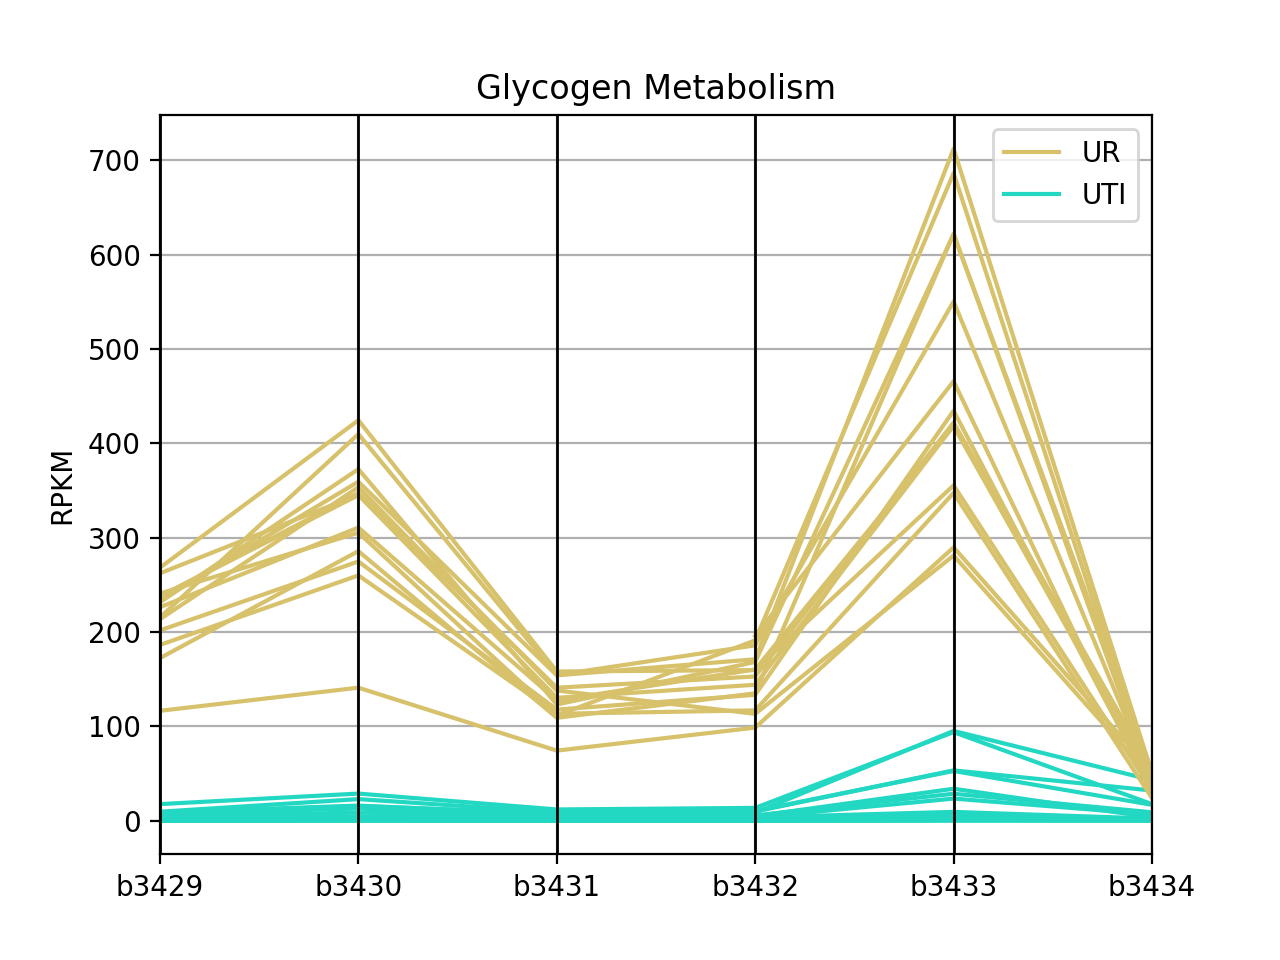

In [28]:
#Glycogen metabolism
plt.figure()
ax = pd.tools.plotting.parallel_coordinates(gpg_df, 'names')
ax.set_ylabel("RPKM")
ax.set_title("Glycogen Metabolism")

<IPython.core.display.Javascript object>


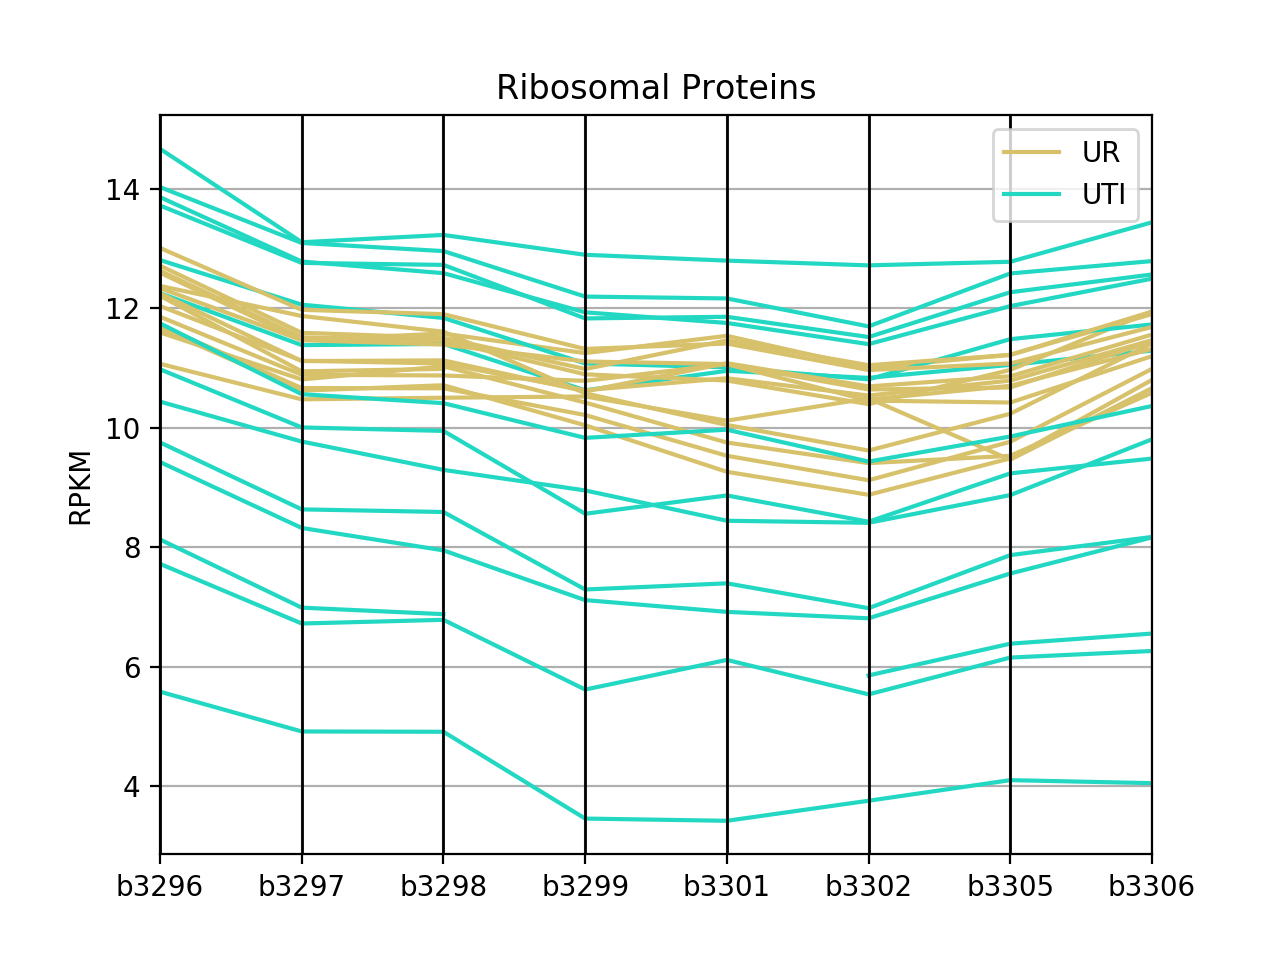

In [26]:
ribo = [
       'b3296',
       'b3297',
       'b3298',
       'b3299',
    'b3301','b3302', 
'b3305', 'b3306']
ribo_df = counts2.ix[ribo]
to_keep = [c for c in list(ribo_df.columns) if 'RPKM' in c and 'seq' not in c]
ribo_df = ribo_df[to_keep].T
ribo_df = np.log2(ribo_df+1)
ribo_df['names'] = [i.split("_")[1] for i in list(ribo_df.index)]
ribo_df.head()
plt.figure()
ax2 = pd.tools.plotting.parallel_coordinates(ribo_df, 'names')
ax2.set_ylabel("RPKM")
ax2.set_title("Ribosomal Proteins")


2.3219280948873622